In [77]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 0 0 1 1 2 0 1 1 1 0 0 1 0 1 1 1 1 2 0 1 1 0 1 0 2 0 1 1 0]


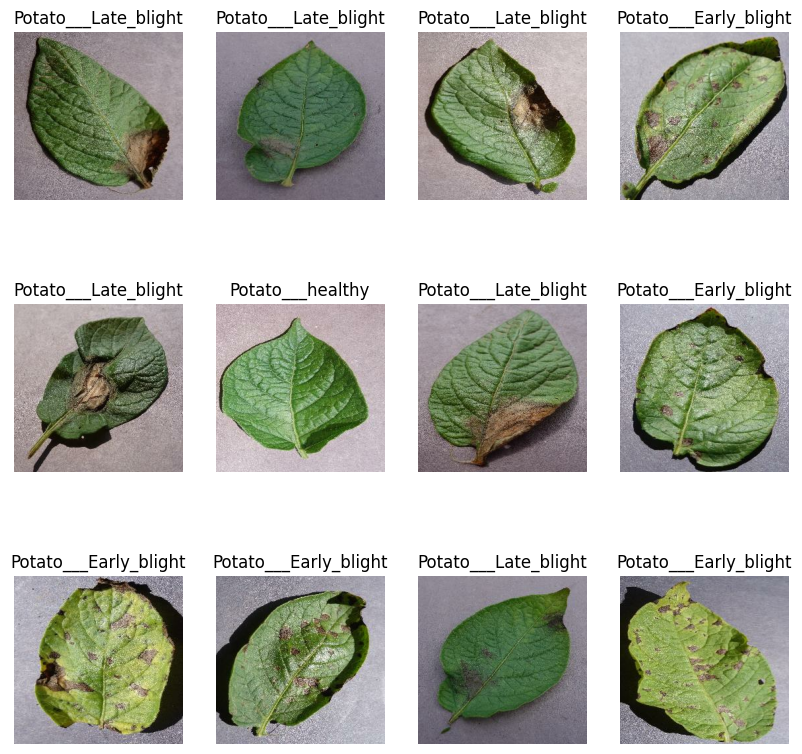

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# lets split the dataset into training and validation sets
trainn_size = 0.8
len(dataset)*trainn_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_bds = test_ds.skip(6)
len(test_ds)

14

In [14]:
def get_dataset_partitions_tf(ds, train_size=0.8, val_size=0.1, test_size=0.1):
    ds_size = len(ds)
    train_size = int(train_size * ds_size)
    val_size = int(val_size * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [30]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# model.build(input_shape = input_shape)

In [31]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])

In [39]:
history = model.fit(
    train_ds,
    epochs = 15,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 1.0000 - loss: 1.2716e-04 - val_accuracy: 0.9844 - val_loss: 0.1493
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 1.0000 - loss: 7.7879e-05 - val_accuracy: 0.9844 - val_loss: 0.1498
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 1.0000 - loss: 5.4412e-05 - val_accuracy: 0.9844 - val_loss: 0.1565
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 1.0000 - loss: 6.1873e-05 - val_accuracy: 0.9844 - val_loss: 0.1581
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 1.0000 - loss: 6.0205e-05 - val_accuracy: 0.9844 - val_loss: 0.1495
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 1.0000 - loss: 4.2957e-05 - val_accuracy: 0.9844 - val_loss: 0.1661
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 1.0000 - loss: 5.4764e-05 - val_accuracy: 0.9844 - val_loss: 0.1502
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 1.0000 - loss: 3.8186e-05 -

In [66]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - accuracy: 0.9829 - loss: 0.0928


In [70]:
print("Test Score:", scores)

Test Score: [0.1750796139240265, 0.9784482717514038]


In [72]:
history

In [73]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [74]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [75]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

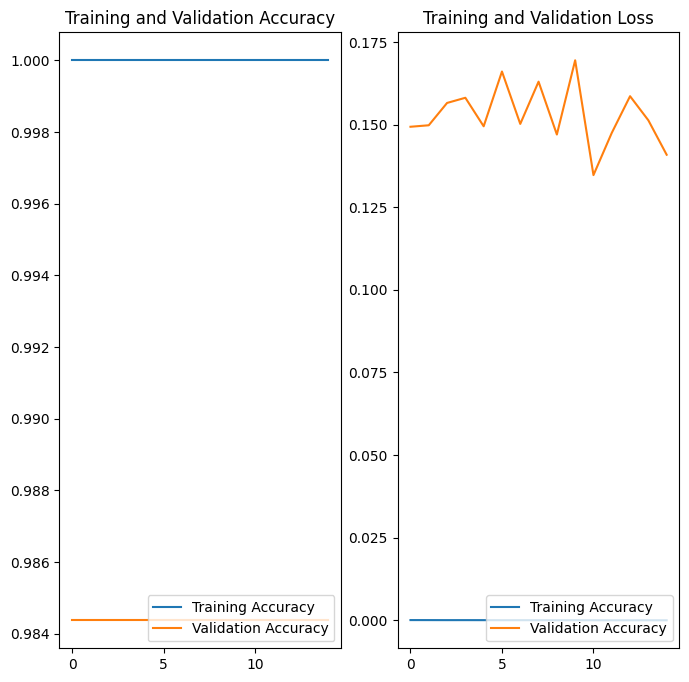

In [79]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(15), acc, label='Training Accuracy')
plt.plot(range(15), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), loss, label='Training Accuracy')
plt.plot(range(15), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First Image to predict
First Image actual Label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Predicted Labels:  Potato___Late_blight


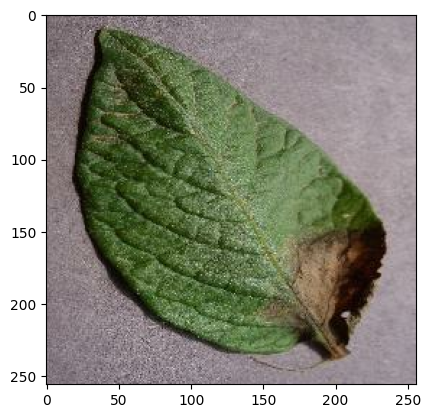

In [83]:
import numpy as np
for batch_image, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print("First Image to predict")
    plt.imshow(first_image)
    print("First Image actual Label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Labels: ", class_names[np.argmax(batch_prediction[0])])

In [84]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round (100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


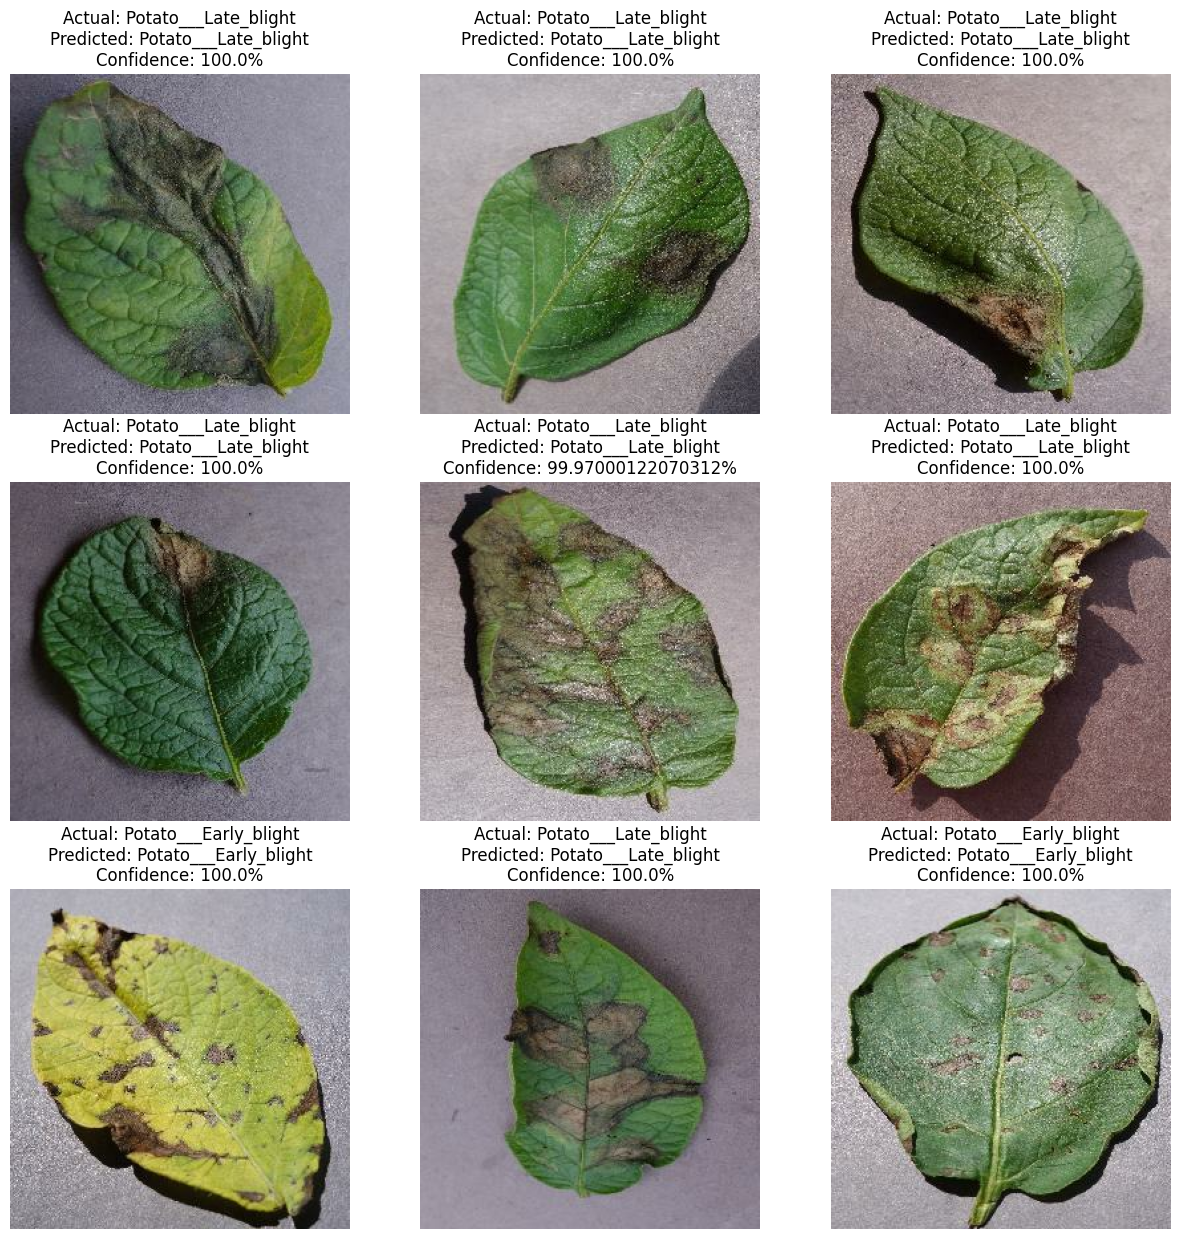

In [86]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

In [87]:
model_version = 1
model.save(f"saved_models/{model_version}.keras")

In [88]:
model_version = 2
model.save(f"saved_models/{model_version}.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load and export 1.keras
model1 = load_model("saved_models/1.keras")
model1.export("served_models/1")  # Correct way for SavedModel format

# Load and export 2.h5
model2 = load_model("saved_models/2.h5")
model2.export("served_models/2")  # Correct way for SavedModel format


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=served_models/1.